Two high-level analyses:
- Predict performance (accuracy) using a regression
- Classify users into 'bad' vs 'good'--still need to define this but perhaps the threshold is any user < 70% and any user >= 70%

For github issues and brainstorming features and analyses, use github:
- https://github.com/ProjectSidewalk/sidewalk-quality-analysis/issues

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dateutil import parser as parser
import time
from datetime import datetime
users = pd.read_csv('ml-users.csv')

In [125]:
df_interactions = pd.read_csv('ml-interactions.tar.gz', compression='gzip') # load the full gzip tarball
#df_interactions = pd.read_csv('ml-interactions15000.csv')

# Do a little cleanup...
# In my initial analysis, i found that at least one row has a NaN value for an 'action' field. This should
# not happen. So, let's find that row (and others) that have this problem and remove them

# pd.isna checks for missing values (NaN values). It returns a boolean array where the index corresponds to
# row and the value corresponds to True/False indicating whether there is a NaN value
isna_result = pd.isna(df_interactions['action'])

print("Printing all rows where 'action' == NaN...")
display(df_interactions[isna_result])
df_interactions= df_interactions[~isna_result] # we want all rows where isna is False (that is, all rows *without* a NaN for 'action')

# As a test, we can again look for NaN 'action' cells
isna_result = pd.isna(df_interactions['action'])
print("Printing all rows where 'action' == NaN... there should be no rows")
display(df_interactions[isna_result])


Printing all rows where 'action' == NaN...


,ml-interactions.csv,user_id,audit_task_interaction_id,audit_task_id,action,gsv_panorama_id,lat,lng,heading,pitch,zoom,note,temporary_label_id,mission_id


KeyboardInterrupt: 

In [136]:
small= df_interactions[:50000]

In [140]:
def find_action(args):
    for index, word in enumerate(args):  
        if index == 0:
            df_information = df_interactions[df_interactions['action'].str.contains(word)]
        else:
            frames = [df_information, df_interactions[df_interactions['action'].str.contains(word)]]
            df_information = pd.concat(frames)
    return df_information

In [127]:
# Run when testing with smaller 15000 dataset
def find_action(args):
    for index, word in enumerate(args):  
        if index == 0:
            df_information = small[small['action'].str.contains(word)]
        else:
            frames = [df_information, small[small['action'].str.contains(word)]]
            df_information = pd.concat(frames)
    return df_information

In [128]:
def counting_graph (info_type, graph_type, multi_plot, *args):
    user_information = {}
    user_panos = {}
    user_missions = {}
    df_information = find_action(args)
    df_actions_grouped = df_information.groupby(['user_id'])
    df_all_grouped = df_interactions.groupby(['user_id'])
    for index, current_id in enumerate(df_actions_grouped.groups):
        user_information[current_id] = len(df_actions_grouped.get_group(current_id)), users[' accuracy'][index]
        if multi_plot:
            user_panos[current_id] = df_all_grouped.get_group(current_id)['gsv_panorama_id'].nunique()
            user_missions[current_id] = df_all_grouped.get_group(current_id)['mission_id'].nunique()
    if graph_type == 'scatter_plot':
        scatter_plot(info_type, user_information, user_panos, user_missions, multi_plot)
    elif graph_type == 'histogram':
        histogram(info_type, user_information)

In [129]:
def range_graph(info_type, graph_type, *args):
    user_information = {}
    df_information = find_action(args)
    df_actions_grouped = df_information.groupby(['user_id'])
    for index, current_id in enumerate(df_actions_grouped.groups):
        current_min = df_actions_grouped.get_group(current_id).min()
        current_max = df_actions_grouped.get_group(current_id).max()
        current_accuracy = users[' accuracy'][index]
        user_information[current_id] = current_max - current_min, current_accuracy
    if graph_type == 'scatter_plot' :
        scatter_plot(info_type, user_information, None, None, False)

In [130]:
def time_graph(info_type, *args):
    user_panos = {}
    user_missions = {}
    df_info  = find_action(args)
    df_per_pano = df_info.groupby(['user_id', 'gsv_panorama_id'])
    df_per_mission = df_info.groupby(['user_id','mission_id'])
    current_group_times = []
    for name,group_pano in df_per_pano:
        for current_datetime in group_pano['ml-interactions.csv']:
            current_group_times.append(parser.parse(current_datetime))
        if name[0] in user_panos:
            user_panos[name[0]] = user_panos[name[0]] + (max(current_group_times) - min(current_group_times)).total_seconds()
        else:
            user_panos[name[0]] = (max(current_group_times) - min(current_group_times)).total_seconds()
    for name,group_mission in df_per_mission:
        for current_datetime in group_mission['ml-interactions.csv']:
            current_group_times.append(parser.parse(current_datetime))
        if name[0] in df_per_mission:
            user_missions[name[0]] = user_missions[name[0]] + (max(current_group_times) - min(current_group_times)).total_seconds()
        else:
            user_missions[name[0]] = (max(current_group_times) - min(current_group_times)).total_seconds()
    time_scatter_plot(info_type, user_panos, user_missions)

In [131]:
def time_scatter_plot(info_type, user_panos, user_missions):
    f, axs = plt.subplots(1,2,figsize=(12,4))
    plt.subplot(122)
    plt.ylabel('User Accuracy')
    plt.xlabel(info_type + ' per second per Pano')
    for index, entry in enumerate(user_panos.keys()):
        user_info = user_panos.get(entry)
        info = float(user_info)
        accuracy = users[' accuracy'][index]
        plt.plot(info, accuracy, '.', color = 'blue')
    plt.subplot(121)
    plt.ylabel('User Accuracy')
    plt.xlabel(info_type + 'per second per Mission Started')
    for index, entry in enumerate(user_missions.keys()):
        user_info = user_missions.get(entry)
        info = float(user_info)
        accuracy = users[' accuracy'][index]
        plt.plot(info, accuracy, '.', color = 'blue')

In [132]:
def scatter_plot(info_type, user_information, user_panos, user_missions, multi_plot):
    if multi_plot:
        f, axs = plt.subplots(1,3,figsize=(12,4))
        plt.subplot(133)
        plt.ylabel('User Accuracy')
        plt.xlabel(info_type + ' per Pano')
        for entry in user_information.keys():
            user_info = user_information.get(entry)
            info = float(user_info[0]) / float(user_panos[entry])
            accuracy = user_info[1]
            plt.plot(info, accuracy, '.', color = 'blue')
        plt.subplot(132)
        plt.ylabel('User Accuracy')
        plt.xlabel(info_type + ' per Mission Started')
        for entry in user_information.keys():
            user_info = user_information.get(entry)
            info = float(user_info[0]) / float(user_missions[entry])
            accuracy = user_info[1]
            plt.plot(info, accuracy, '.', color = 'blue')
        plt.subplot(131)
    plt.ylabel('User Accuracy')
    plt.xlabel(info_type)
    for entry in user_information.keys():
        user_info = user_information.get(entry)
        info = user_info[0]
        accuracy = user_info[1]
        plt.plot(info, accuracy, '.', color = 'blue')

In [133]:
def histogram(info_type, user_information):
    plt.hist(user_information) 
    plt.xlabel(info_type)
    plt.ylabel('Count')

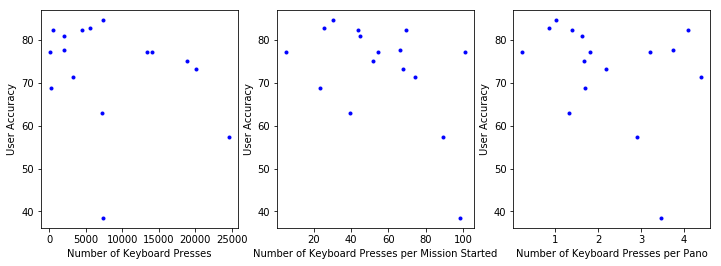

In [85]:
counting_graph('Number of Keyboard Presses', 'scatter_plot', True, 'LowLevelEvent_keydown')

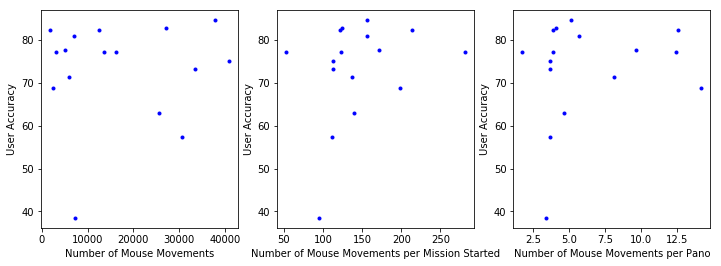

In [86]:
counting_graph('Number of Mouse Movements', 'scatter_plot', True, 'LowLevelEvent_mousedown')

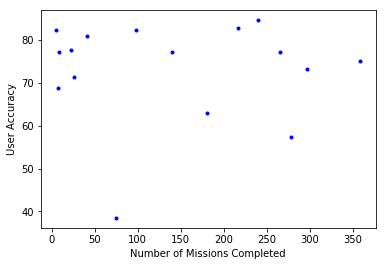

In [14]:
counting_graph('Number of Missions Completed', 'scatter_plot', False, 'MissionComplete')

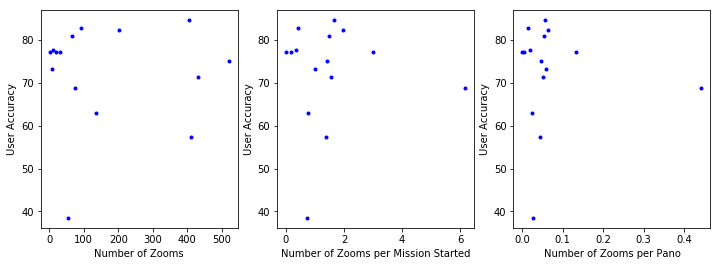

In [21]:
counting_graph('Number of Zooms', 'scatter_plot', True, 'Click_ZoomIn')

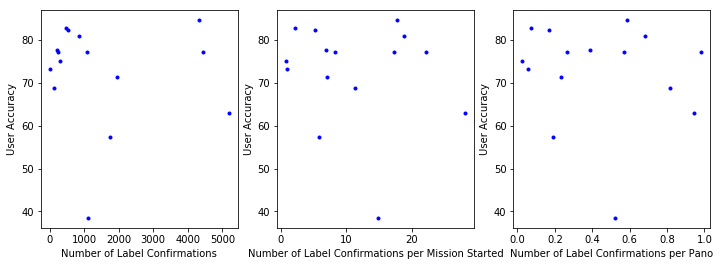

In [63]:
counting_graph('Number of Label Confirmations', 'scatter_plot', True, 'ContextMenu_OKButtonClick')

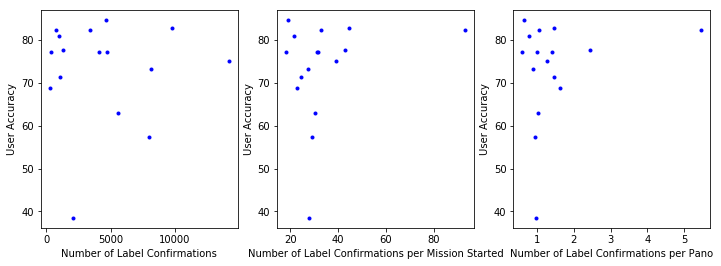

In [24]:
counting_graph('Number of Label Confirmations', 'scatter_plot', True, 'ContextMenu_Close')

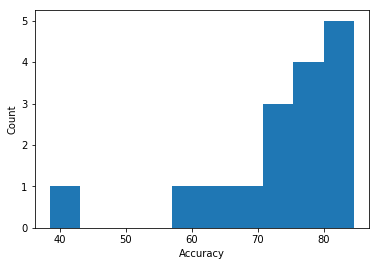

In [90]:
histogram('Accuracy', users[' accuracy'])

In [ ]:
# For the bottom three graphs, I was unable to run the entire dataset without notebooks 
#crashing. Below are when I use just the first 50000 lines of the whole dataset

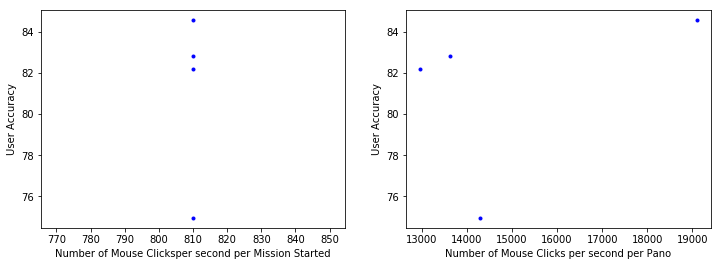

In [138]:
time_graph('Number of Mouse Clicks', 'LowLevelEvent_mousedown')

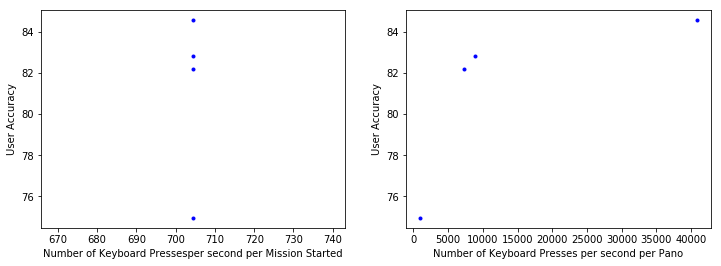

In [139]:
time_graph('Number of Keyboard Presses', 'LowLevelEvent_keydown')

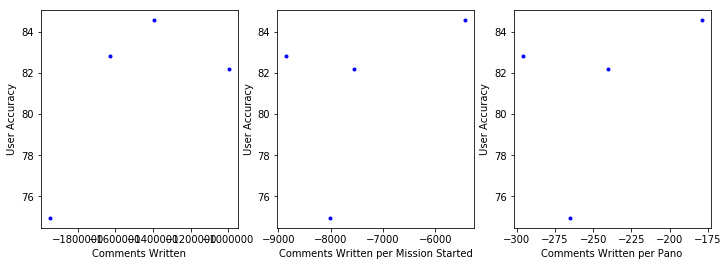

In [137]:
# Number of Comments Written
# in progress
user_information = {}
user_panos = {}
user_missions = {}
df_comments = find_action('ContextMenu_TextBoxBlur')
df_window_closes = find_action('ContextMenu_Close')
df_comments_grouped = df_comments.groupby(['user_id'])
df_window_closes_grouped = df_window_closes.groupby(['user_id'])
df_all_grouped = df_interactions.groupby(['user_id'])
for index, current_id in enumerate(df_comments_grouped.groups):
    user_information[current_id] = len(df_comments_grouped.get_group(current_id)) - len(df_all_grouped.get_group(current_id)), users[' accuracy'][index]
    user_panos[current_id] = df_all_grouped.get_group(current_id)['gsv_panorama_id'].nunique()
    user_missions[current_id] = df_all_grouped.get_group(current_id)['mission_id'].nunique()
scatter_plot('Comments Written', user_information, user_panos, user_missions, True)